In [ ]:
!pip install matchms
!pip install rdkit
!pip install torch_geometric
!pip install pickle5

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 109.6/109.6 kB 2.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 235.1/235.1 kB 9.9 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 29.7/29.7 MB 36.6 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 661.6/661.6 kB 9.6 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for torch_geometric: filename=torch_geometric-2.3.1-py3-none-any.whl size=910476 sha256=4aaeb18b1612f7f3a478c74d1fc7b089fb46e774865640334259bb207464ae55
  Stored in directory: /root/.cache/pip/wheels/ac/dc/30/e2874821ff308ee67dc

In [ ]:
from rdkit.Chem import AllChem
from matchms.importing import load_from_msp
import numpy as np
import os
import random
import glob
import time
import re
import pandas as pd
import pickle
from rdkit import Chem
from rdkit.Chem import Descriptors
import matchms
from matchms import Spectrum

import matplotlib.pyplot as plt
import warnings

from rdkit.Chem.rdmolops import GetAdjacencyMatrix

import torch
from torch.nn import Linear
import torch.nn.functional as F 
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!cp /content/drive/MyDrive/NIST_LIB/model_base_big.py model_base_big.py
!cp /content/drive/MyDrive/NIST_LIB/validation_metrics.py validation_metrics.py

In [ ]:
import model_base_big
import validation_metrics

In [ ]:
with open("/content/drive/MyDrive/NIST_ECF/validation_subset_pow.pkl", 'rb') as handle:
    validation_dataset  = pickle.load(handle)

In [ ]:
REGEX = "*.pt"
PATH_MODELS = "/content/drive/MyDrive/NIST_ECF/DENSE_BIG_ECF_POW"
BATCH = 64
MAX_INTENSITY = 999.

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
matchms.set_matchms_logger_level("ERROR")

# VALIDATION PREDICTION

In [ ]:
def spectrum_preperation(tensor, max_intensity):
    # spectrum preparation
    # input:
    # tensor: (1, len_of_spectrum)
    # max_intensity: float value of highest value peak
    # return:
    # spectrum object from msml
    spectrum = tensor.detach().numpy()
    spectrum = spectrum / spectrum.max() * max_intensity

    position = np.nonzero(spectrum)[0]
    intensity = spectrum[position]

    spectrum = Spectrum(mz=position.astype(float),
                    intensities=intensity)

    return spectrum

In [ ]:

def load_each_model(path, regex):
    # return path to all models in given folder
    absolute_folder_path = os.path.abspath(path)
    pt_files = glob.glob(os.path.join(absolute_folder_path, '*.pt'))
    return pt_files

def find_validation_files(folder_path, regex):
    # Given a folder path, returns a list of all files with a 'validation<digits>.pkl'
    
    absolute_folder_path = os.path.abspath(folder_path)
    validation_files = []
    regex = regex
    for filename in os.listdir(absolute_folder_path):
        if re.match(regex, filename):
            validation_files.append(os.path.join(absolute_folder_path, filename))
    return validation_files

In [ ]:
def give_model_epoch(model_path):
    # model should have in format name ..path/number/pt
    file_name = os.path.basename(model_path)
    file_name_without_ext = os.path.splitext(model_path)[0]

    last_num_str = ''
    for c in reversed(file_name_without_ext):
        if c.isdigit():
            last_num_str = c + last_num_str
        else:
            break
    return last_num_str

In [ ]:

def load_models_and_predict(models_path, model_category, loader):
    # for each model make prediction and save it in directory
    for model_path in models_path:
        model = model_category
        checkpoint = torch.load(model_path, map_location=torch.device('cpu'))
        model.load_state_dict(checkpoint['model_state_dict'])
        model.eval()
        
        pred_concat = torch.tensor([])
        true_concat = torch.tensor([])

        for batch in loader:
            # Use GPU
            x = batch[0].float().to(device)  
            molecular_weight = batch[1].to(device)  
            y = batch[2].to(device)        
            # Passing the node features and the connection info
            pred = model(x, molecular_weight) 

            true_concat = torch.cat((true_concat, y), 0)
            pred_concat = torch.cat((pred_concat, pred), 0)
        
        tensor_prediction = {'true': true_concat, 'pred': pred_concat}

        with open(PATH_MODELS +'/validation' + give_model_epoch(model_path) + '.pkl', 'wb') as f:
            pickle.dump(tensor_prediction, f)
        
        # save ram memory
        model = None
        del model
        true_concat = None
        del true_concat
        pred_concat = None
        del pred_concat
        tensor_prediction = None
        del tensor_prediction


In [ ]:
validation_loader_unshuffled = DataLoader(validation_dataset, 
                         batch_size=BATCH, shuffle=False)
MODEL_CLASS = model_base_big.DENSE_BIG()
models_path = load_each_model(PATH_MODELS, REGEX)

load_models_and_predict(models_path, MODEL_CLASS, validation_loader_unshuffled)

In [ ]:
def compute_statistics_for_validation(validations_paths):
    # compute dot product and stein dot product on files we save in load_models_and_predict

    result = dict()
    for validation in validations_paths:

        with open(validation, 'rb') as f:
            loaded_validation = pickle.load(f)
        
        true_concat = loaded_validation['true']
        pred_concat = loaded_validation['pred']


        sim_dp = matchms.similarity.CosineGreedy(mz_power=1., intensity_power=.5)
        sim_sdp = matchms.similarity.CosineGreedy(mz_power=3., intensity_power=.6)

        dp =[]
        sdp = []
     
        for true_tensor, pred_tensor in zip(true_concat, pred_concat):
            true_spectrum = spectrum_preperation(true_tensor, MAX_INTENSITY)

            pred_spectrum = spectrum_preperation(pred_tensor, MAX_INTENSITY)

            dp.append(sim_dp.pair(true_spectrum, pred_spectrum))
            sdp.append(sim_sdp.pair(true_spectrum, pred_spectrum))

        dp = np.array([ float(s['score']) for s in dp ])
        sdp = np.array([ float(s['score']) for s in sdp ])
        result[validation] = (dp, sdp)
       
    return result

In [ ]:
REGEX_VALIDATION = r'^validation\d+\.pkl$'
validation_paths = find_validation_files(PATH_MODELS, REGEX_VALIDATION)
statistics_validation = compute_statistics_for_validation(validation_paths)

In [ ]:
def convolved_mean(path_models, statistics_validation):
    value = statistics_validation[path_models + "/validation10.pkl"]
    value1 = statistics_validation[path_models + "/validation100.pkl"]
    value2 = statistics_validation[path_models + "/validation200.pkl"]
    value3 = statistics_validation[path_models + "/validation290.pkl"]

    win = 50
    smooth_dp = np.convolve(value[0], np.ones(win)/win, mode='valid')
    smooth_sdp = np.convolve(value[1], np.ones(win)/win, mode='valid')

    plt.figure(figsize=(10, 8))

    # plot 1
    plt.subplot(2, 2, 1)
    plt.plot(smooth_dp,label='dp')
    plt.plot(smooth_sdp,label='sdp')
    plt.title('Convolved mean at 10')
    plt.legend()

    # plot 2
    plt.subplot(2, 2, 2)
    smooth_dp = np.convolve(value1[0], np.ones(win)/win, mode='valid')
    smooth_sdp = np.convolve(value1[1], np.ones(win)/win, mode='valid')
    plt.plot(smooth_dp,label='dp')
    plt.plot(smooth_sdp,label='sdp')
    plt.title('Convolved mean at 100')
    plt.legend()

    # plot 3
    plt.subplot(2, 2, 3)
    smooth_dp = np.convolve(value2[0], np.ones(win)/win, mode='valid')
    smooth_sdp = np.convolve(value2[1], np.ones(win)/win, mode='valid')
    plt.plot(smooth_dp,label='dp')
    plt.plot(smooth_sdp,label='sdp')
    plt.title('Convolved mean at 200')
    plt.legend()

    # plot 4
    plt.subplot(2, 2, 4)
    smooth_dp = np.convolve(value3[0], np.ones(win)/win, mode='valid')
    smooth_sdp = np.convolve(value3[1], np.ones(win)/win, mode='valid')
    plt.plot(smooth_dp,label='dp')
    plt.plot(smooth_sdp,label='sdp')
    plt.title('Convolved mean at 300')
    plt.legend()

    plt.show()

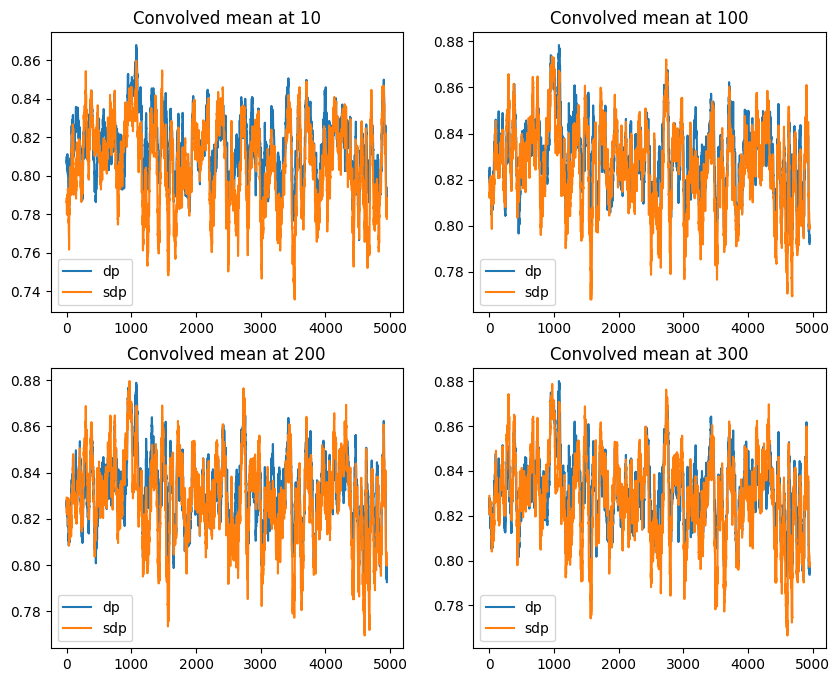

In [ ]:
convolved_mean(PATH_MODELS, statistics_validation)

In [ ]:
def histograms_convolved(path_models, statistics_validation):
    value = statistics_validation[path_models + "/validation100.pkl"]
    value2 = statistics_validation[path_models + "/validation200.pkl"]
    value3 = statistics_validation[path_models + "/validation290.pkl"]

    bins = 70
    plt.figure(figsize=(10,4))
    plt.subplot(121)
    plt.hist(value[0], label='100', bins=bins, alpha=0.5)
    plt.hist(value2[0], label='200', bins=bins, alpha=0.5)
    plt.hist(value3[0], label='300', bins=bins, alpha=0.5)
    plt.title('DP at 100, 200 and 300 epoch')
    plt.legend()
    plt.subplot(122)
    plt.hist(value[1], label='100', bins=bins, alpha=0.5)
    plt.hist(value2[1], label='200', bins=bins, alpha=0.5)
    plt.hist(value3[1], label='300', bins=bins, alpha=0.5)
    plt.title('SDP at 100, 200 and 300 epoch')
    plt.legend()
    plt.show()

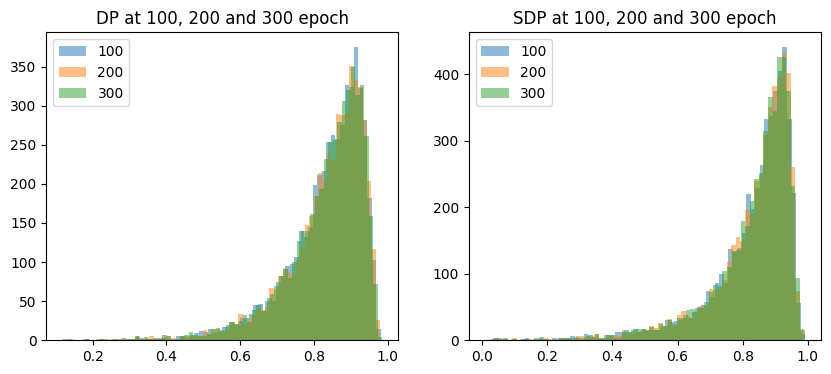

In [ ]:
histograms_convolved(PATH_MODELS, statistics_validation)

In [ ]:
def get_validation_number(file_path):
    # function to number to sort outputs of models
    match = re.search(r'validation(\d+)\.', file_path)
    if match:
        return int(match.group(1))
    else:
        return None

In [ ]:
def plot_convolve_mean(statistics_validation):
    sorted_files = sorted(statistics_validation.keys(), key=get_validation_number)
    for file_name in sorted_files:
        value = statistics_validation[file_name]
        dp = value[0]
        sdp = value[1]

        win = 50
        smooth_dp = np.convolve(dp, np.ones(win)/win, mode='valid')
        smooth_sdp = np.convolve(sdp, np.ones(win)/win, mode='valid')

        plt.title(f"Validation at epoch {get_validation_number(file_name)}")
        plt.plot(smooth_dp,label='dp')
        plt.plot(smooth_sdp,label='sdp')
        plt.legend()

        plt.show()



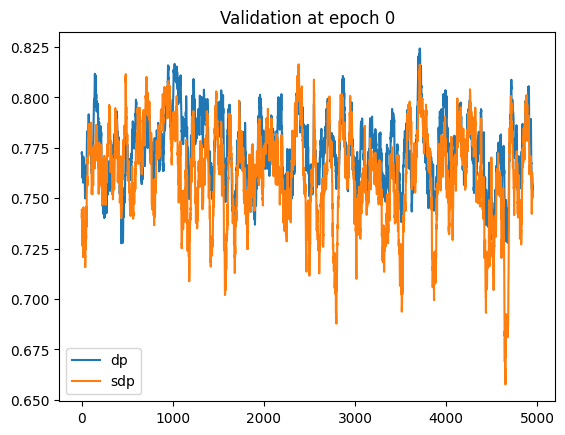

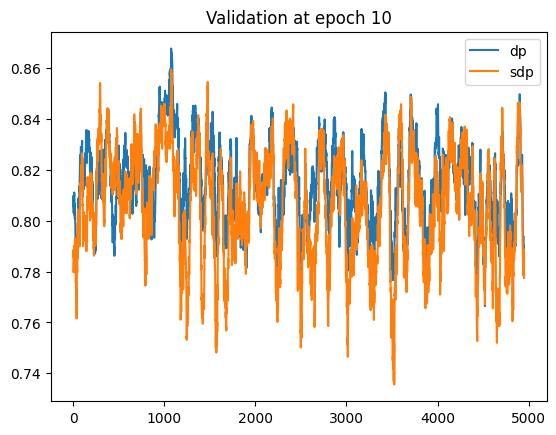

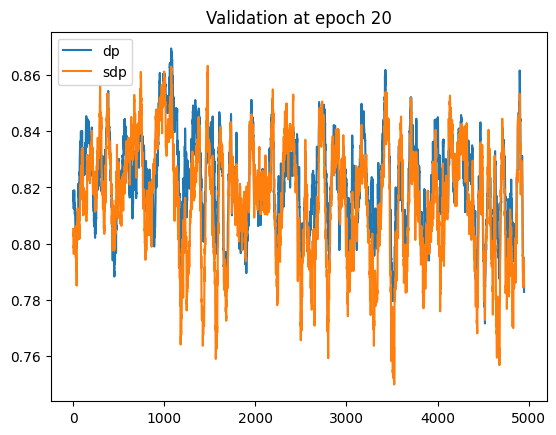

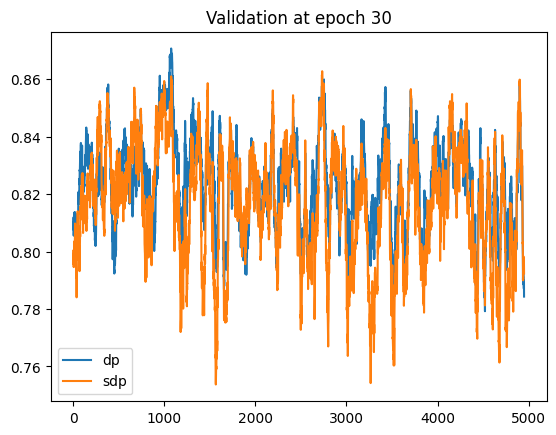

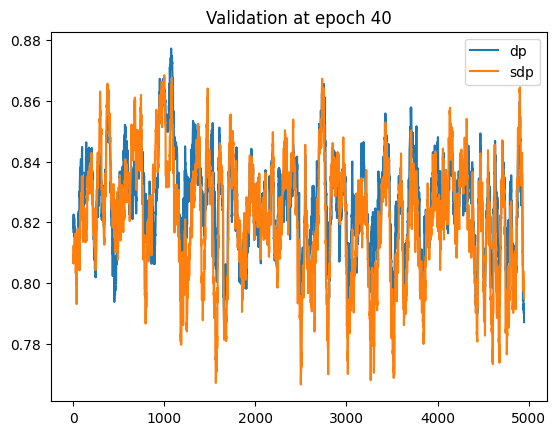

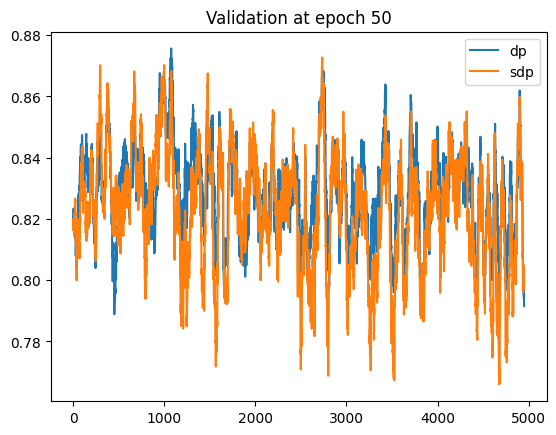

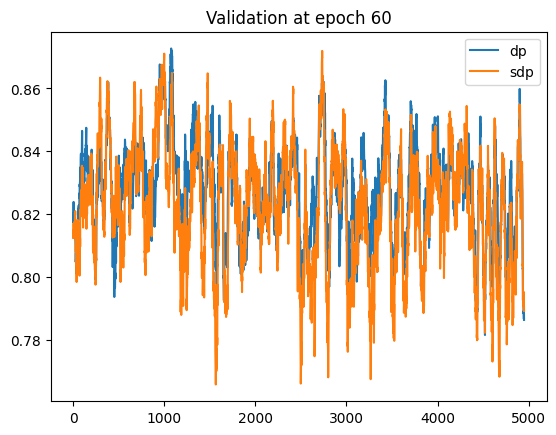

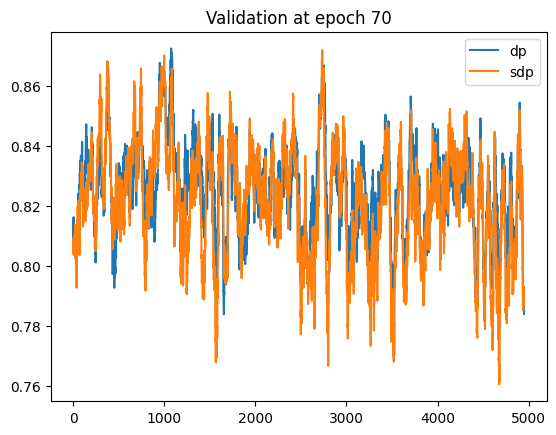

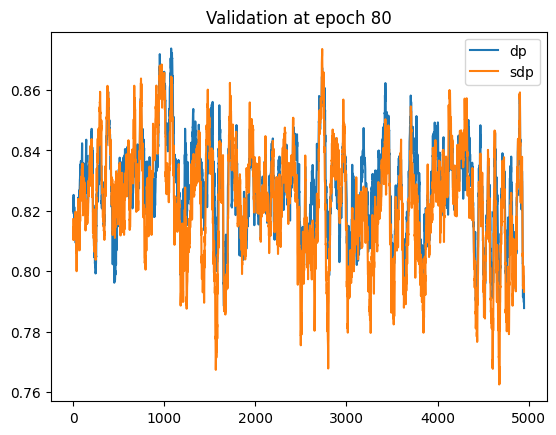

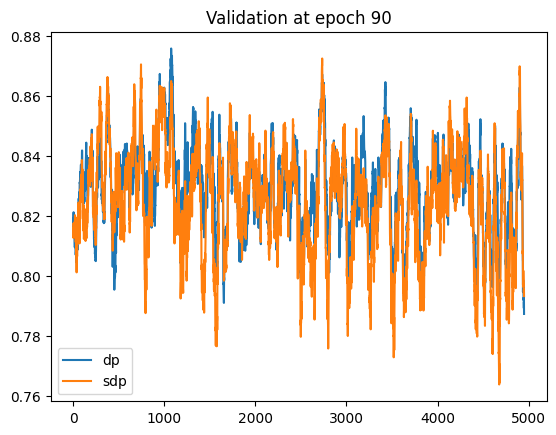

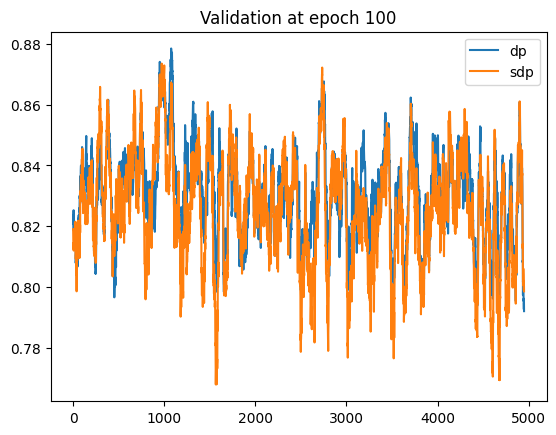

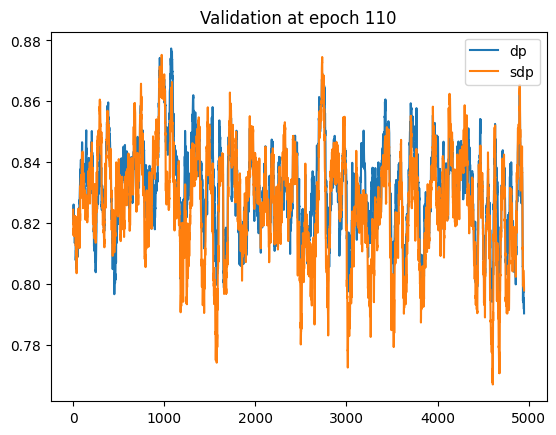

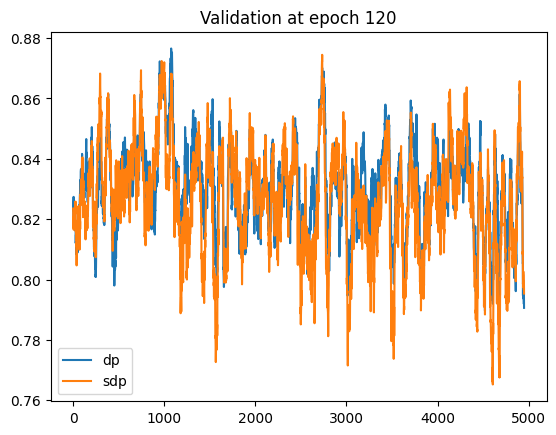

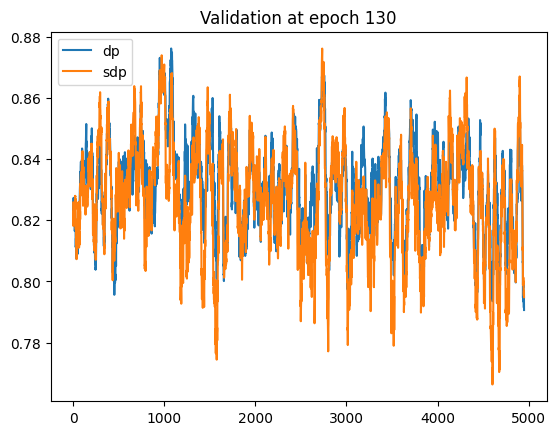

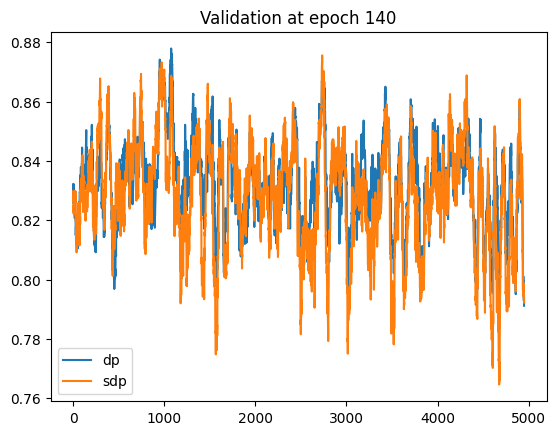

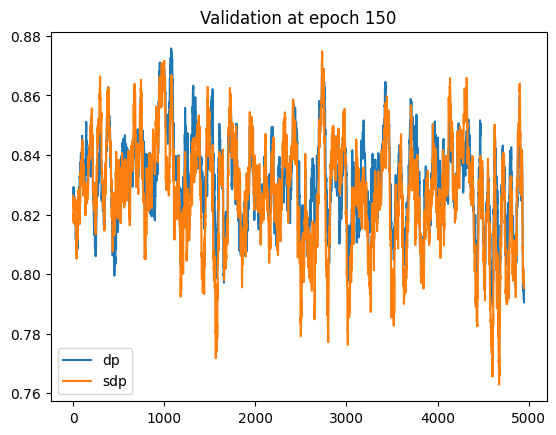

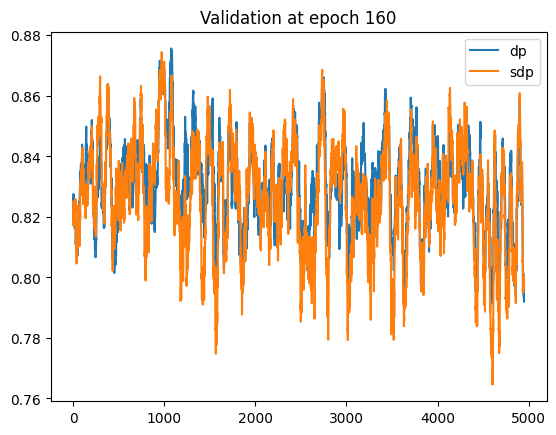

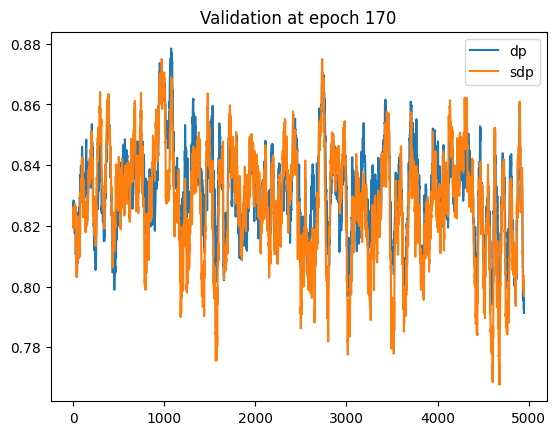

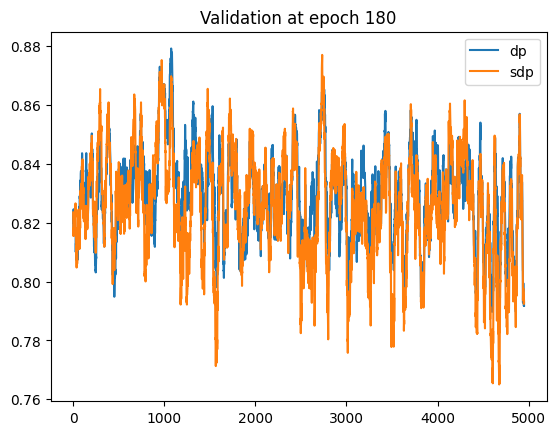

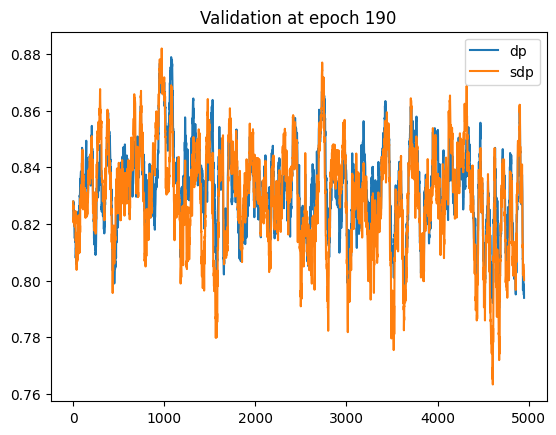

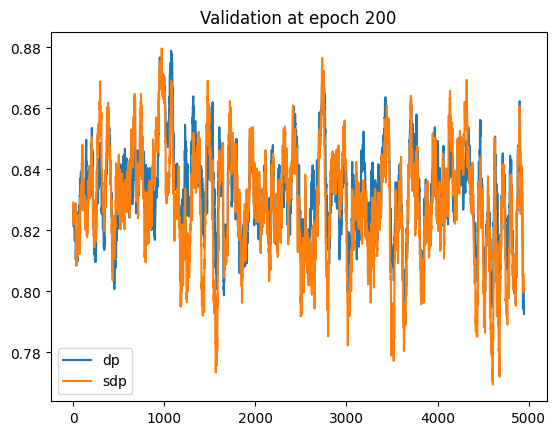

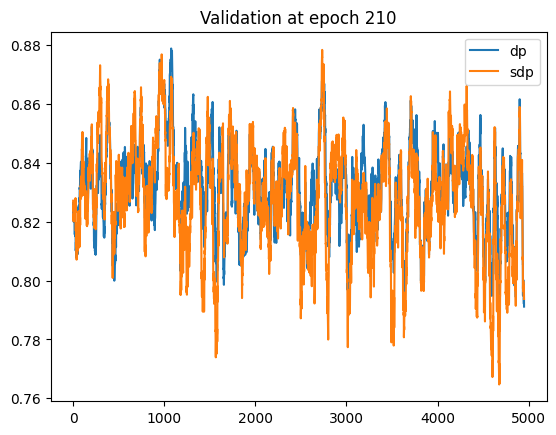

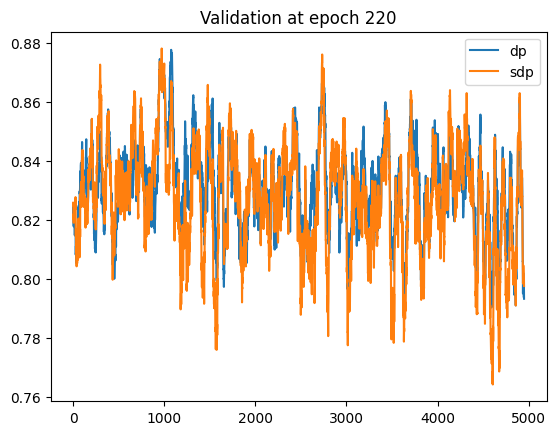

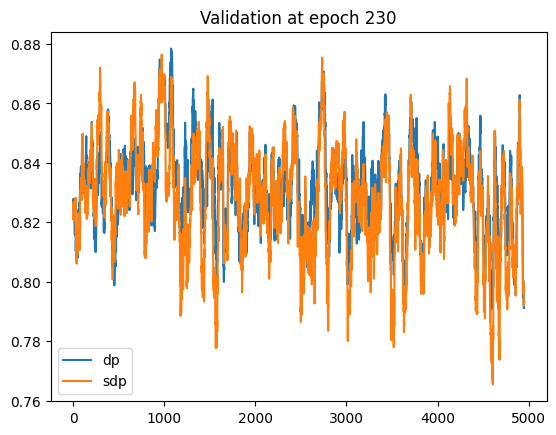

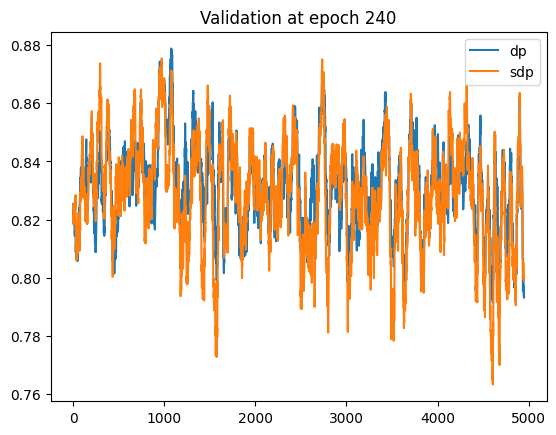

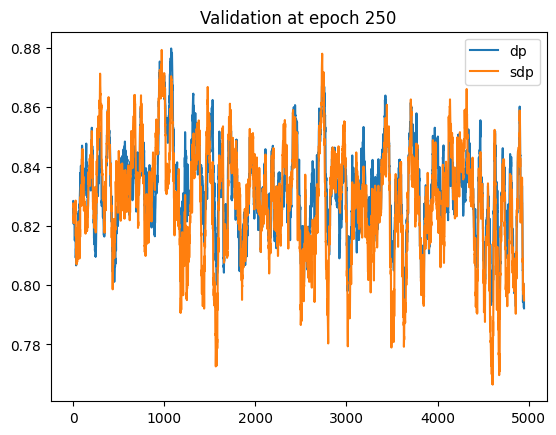

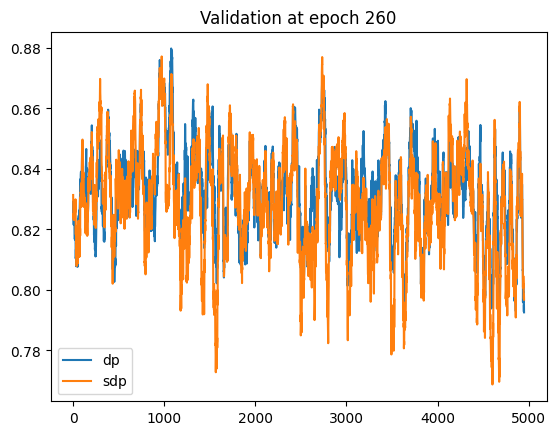

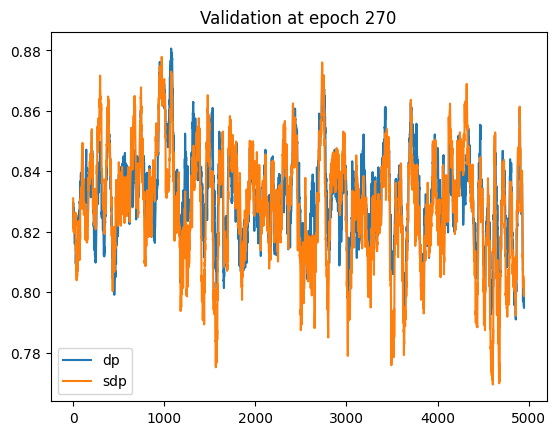

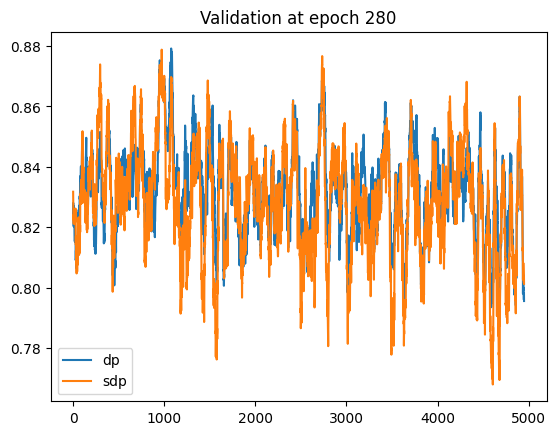

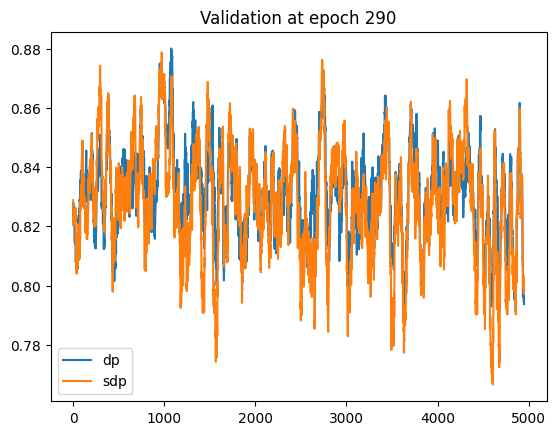

In [ ]:
plot_convolve_mean(statistics_validation)

In [ ]:
def plot_histograms(statistics_validation):
    sorted_files = sorted(statistics_validation.keys(), key=get_validation_number)
    for file_name in sorted_files:
        value = statistics_validation[file_name]
        dp = value[0]
        sdp = value[1]

        bins = 70
        plt.figure(figsize=(10,4))
        plt.subplot(121)
        plt.hist(dp,label='dp',bins=bins)
        plt.title('dp')
        plt.subplot(122)
        plt.hist(sdp,label='sdp',bins=bins)
        plt.title('sdp')
        plt.suptitle(f"Validation at epoch {get_validation_number(file_name)}")
        plt.show()

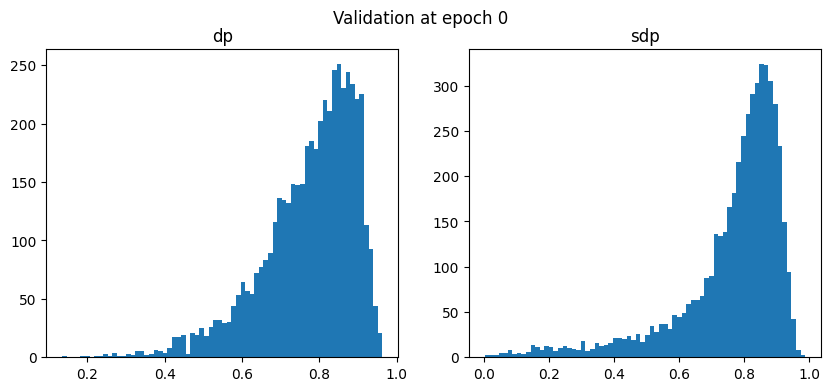

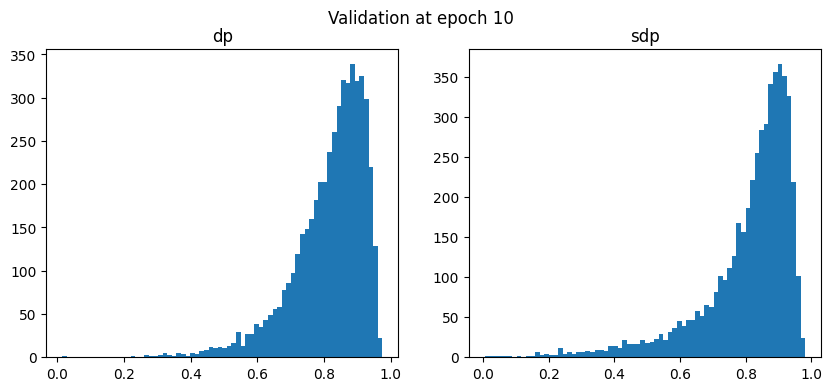

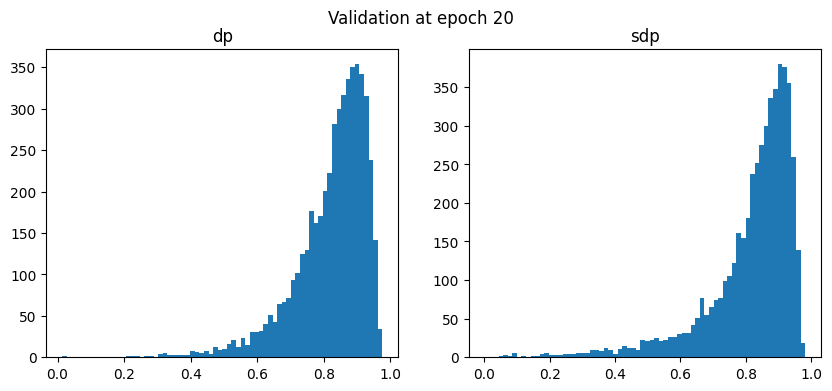

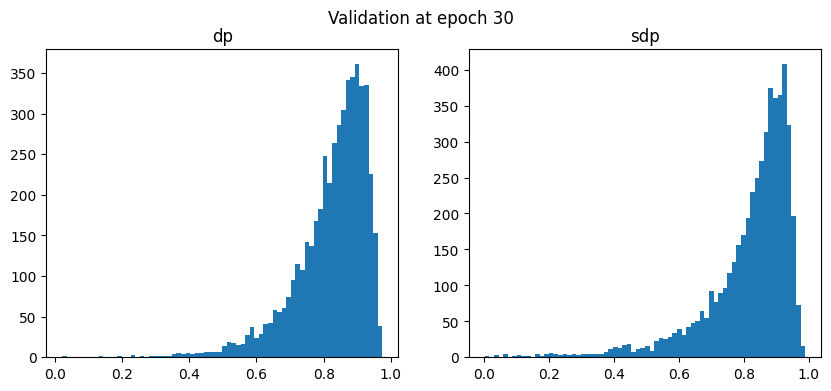

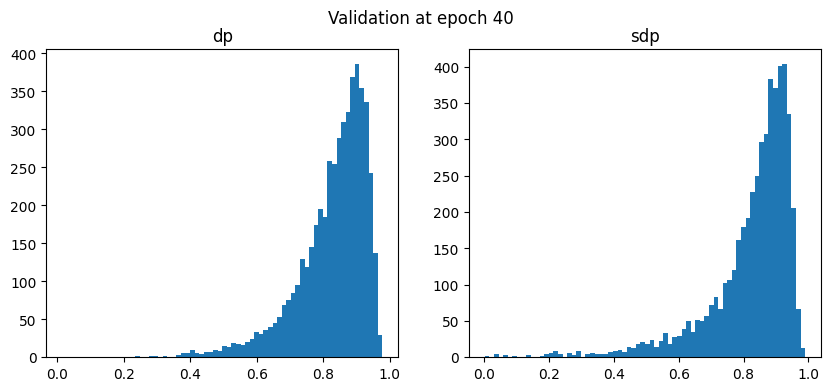

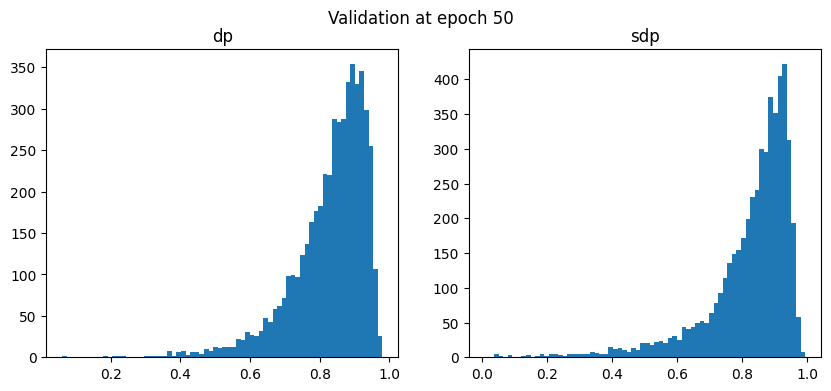

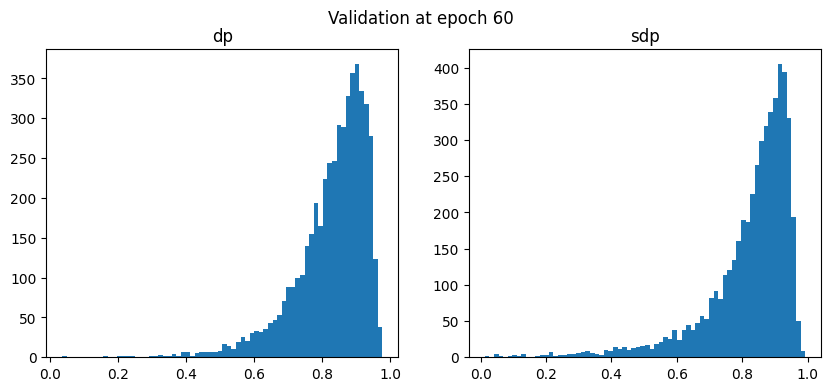

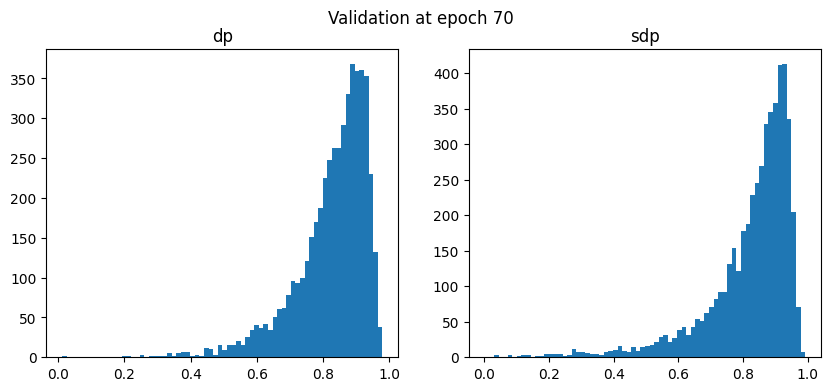

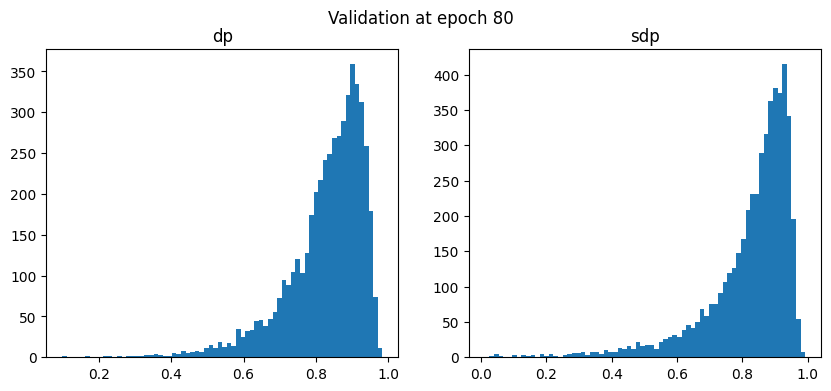

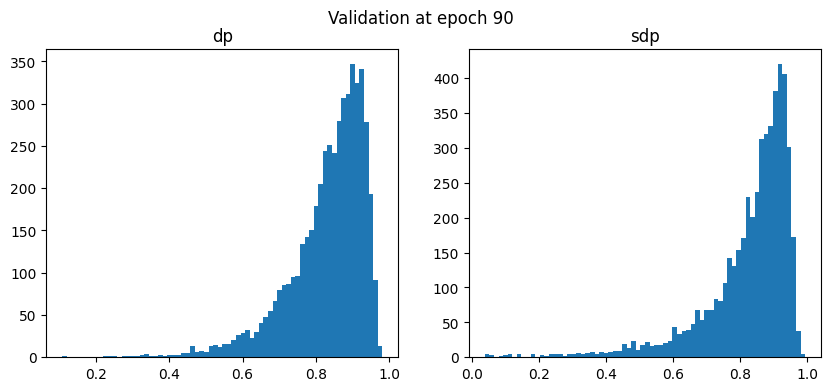

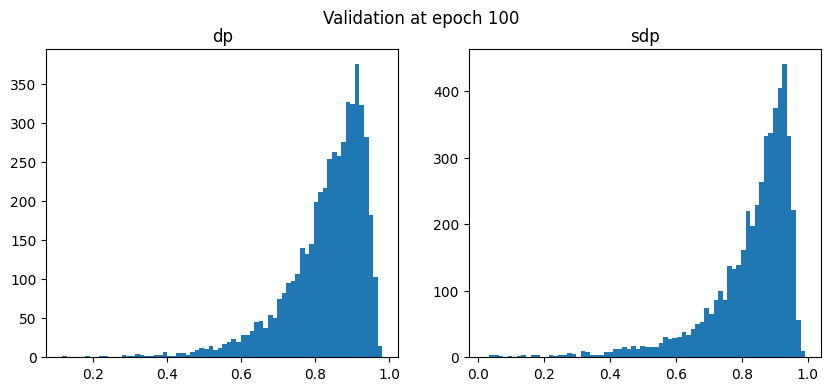

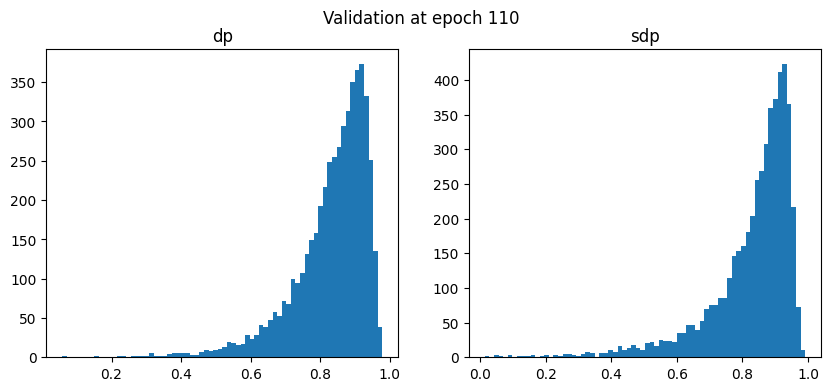

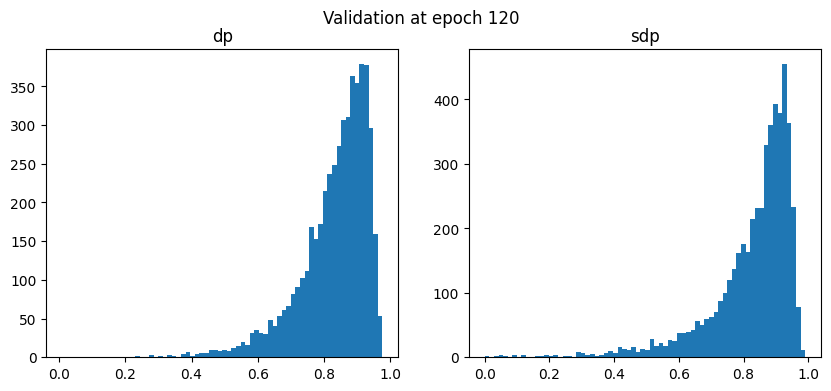

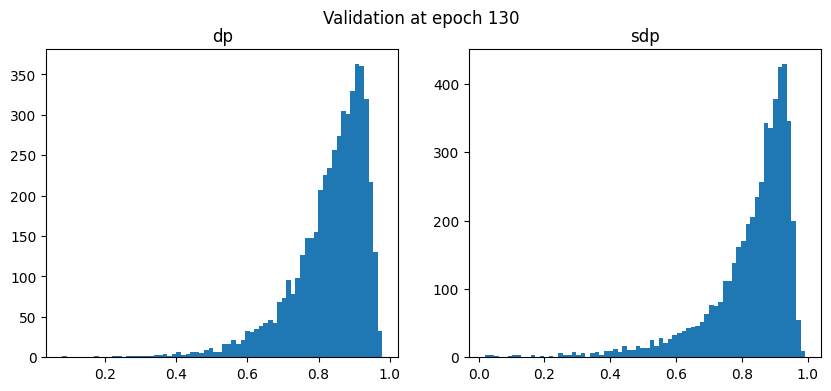

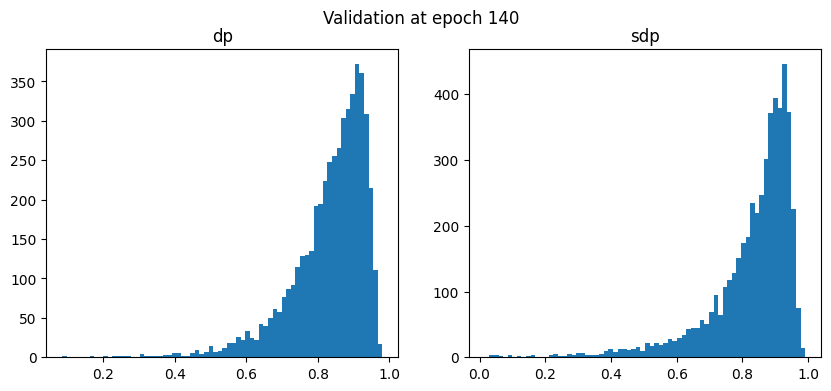

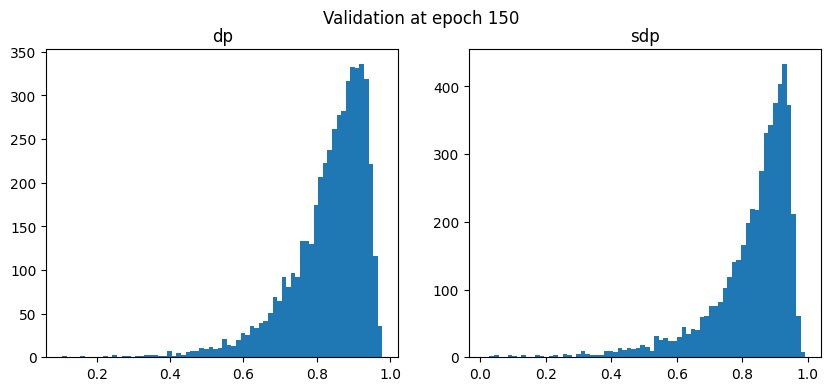

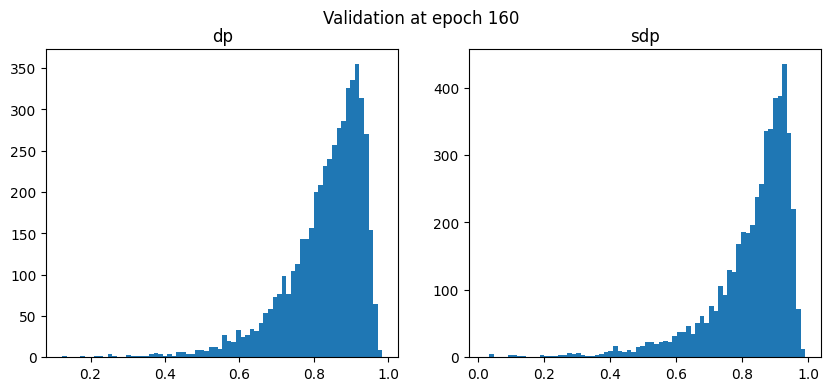

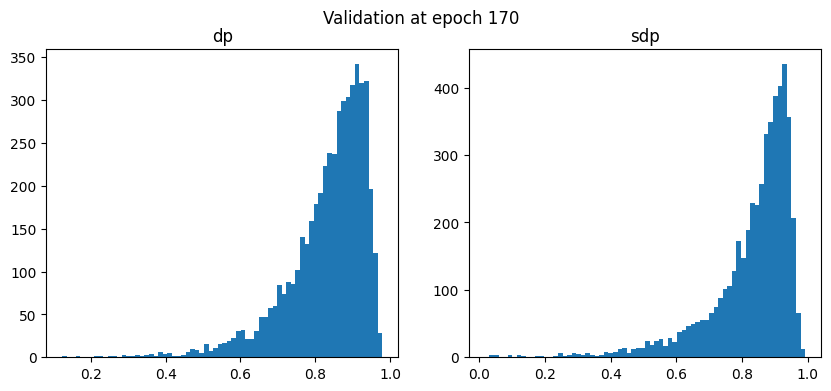

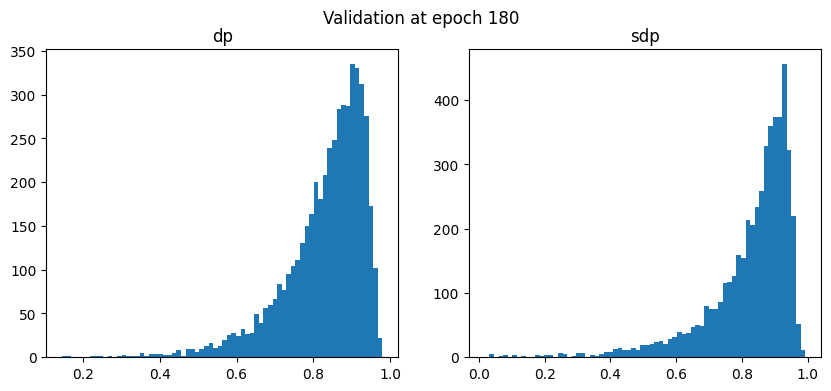

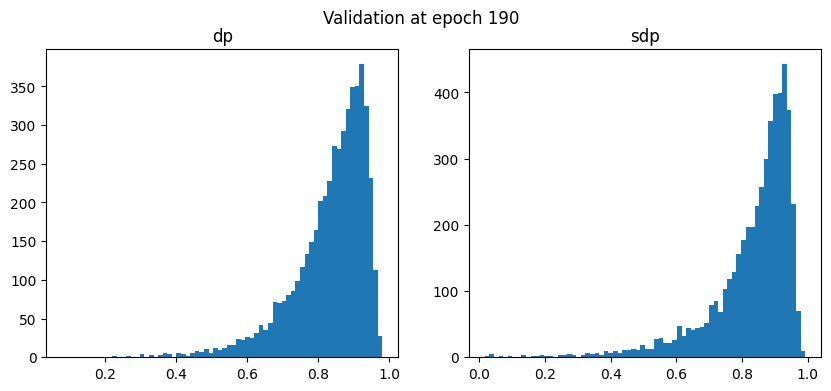

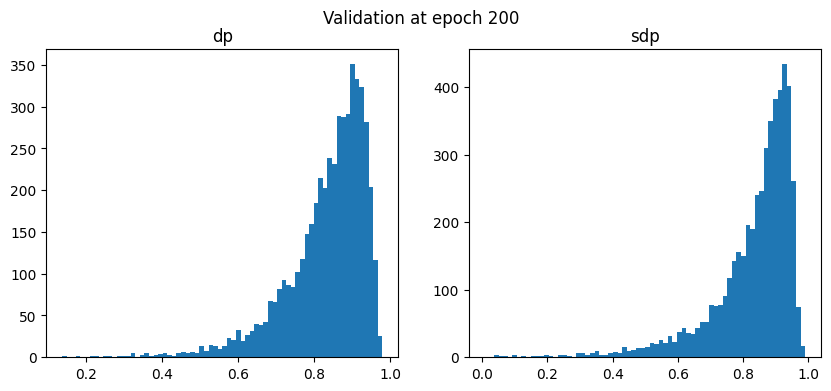

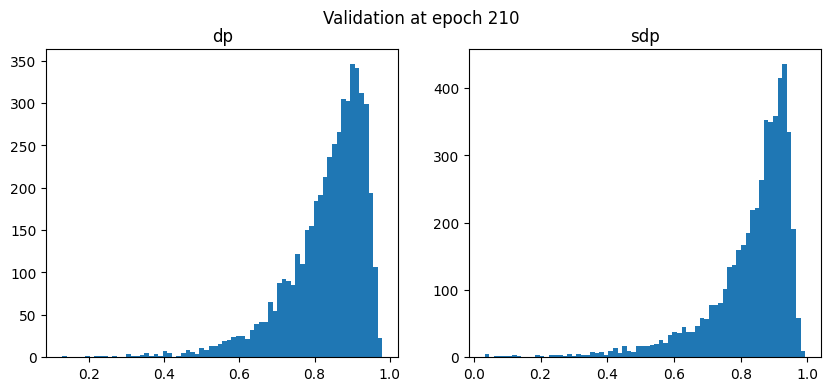

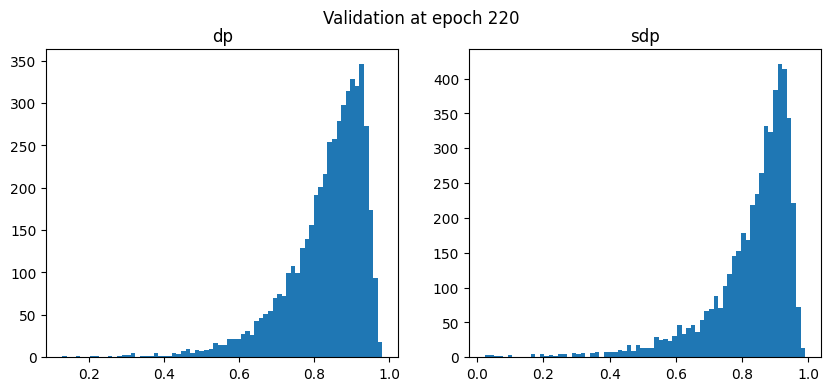

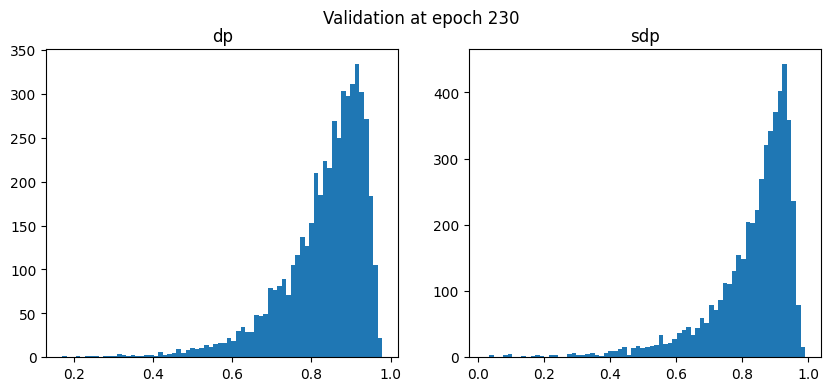

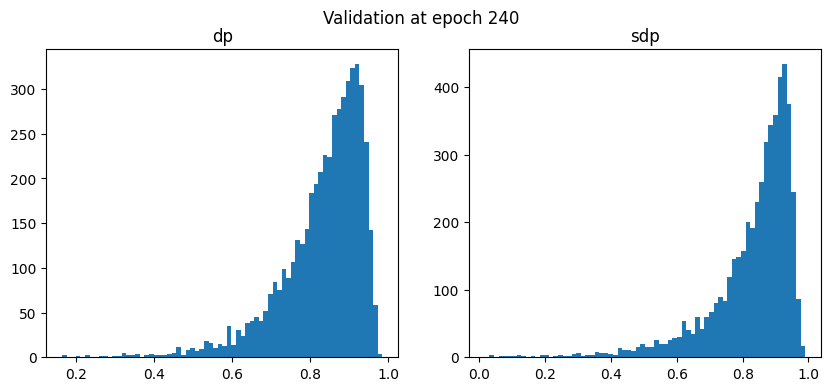

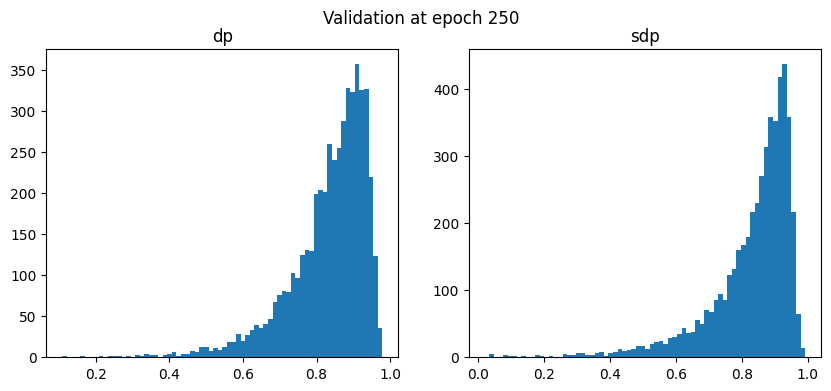

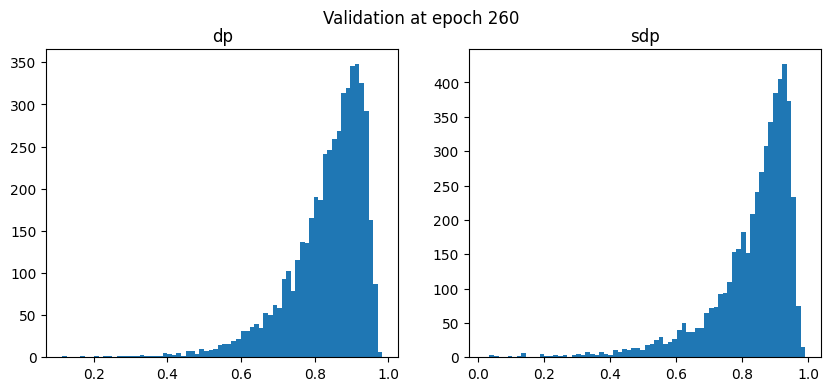

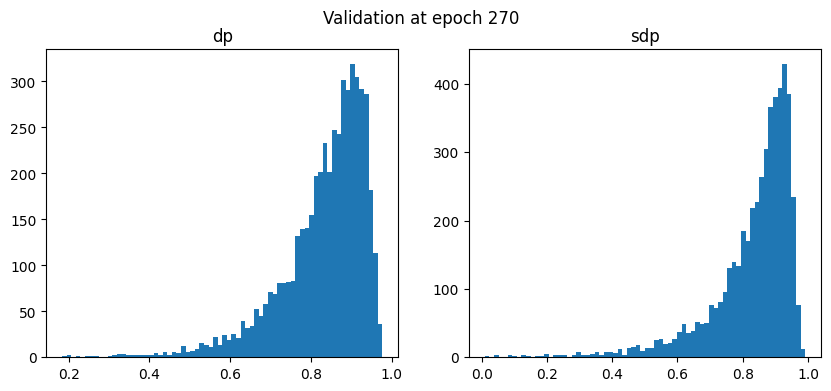

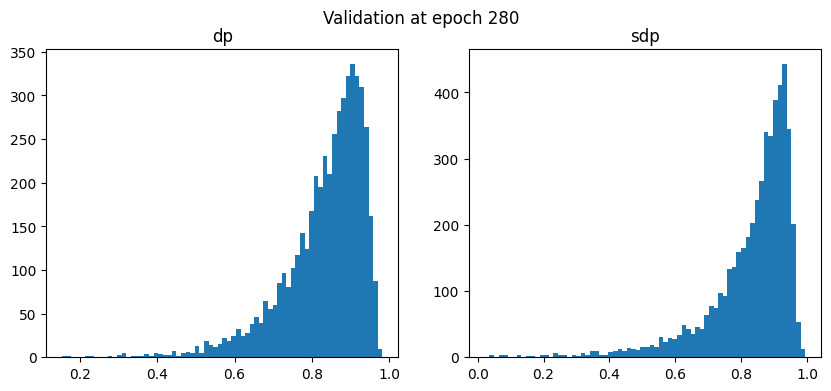

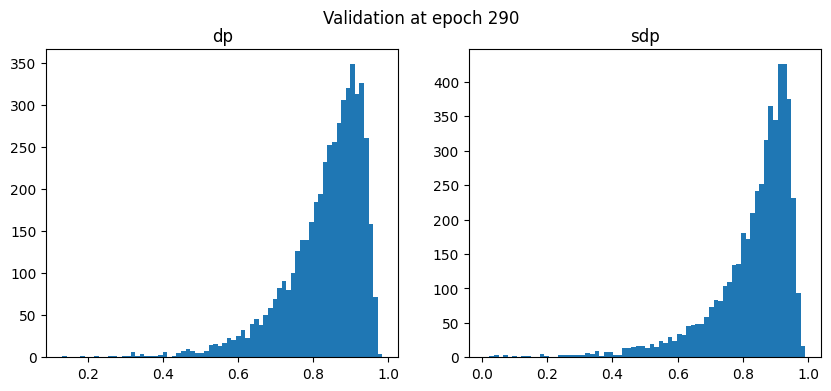

In [ ]:
plot_histograms(statistics_validation)

In [ ]:
def print_mean_and_deviation(statistics_validation):
    for key, value in statistics_validation.items():
        dp = value[0]
        sdp = value[1]
        
        print(key)
        print(f" | DotProduct mean is: {np.mean(dp)} and standard deviation is {np.std(dp)}")
        print(f" | SteinDotProduct mean is: {np.mean(sdp)} and standard deviation is {np.std(sdp)}")
        print()

In [ ]:
print_mean_and_deviation(statistics_validation)

/content/drive/MyDrive/NIST_ECF/DENSE_BIG_ECF_POW/validation0.pkl
 | DotProduct mean is: 0.7736153659375088 and standard deviation is 0.12107073299973281
 | SteinDotProduct mean is: 0.7616642248874911 and standard deviation is 0.1650567542785195

/content/drive/MyDrive/NIST_ECF/DENSE_BIG_ECF_POW/validation10.pkl
 | DotProduct mean is: 0.8148344332806523 and standard deviation is 0.1099839123967504
 | SteinDotProduct mean is: 0.8057412601301074 and standard deviation is 0.14485965046946042

/content/drive/MyDrive/NIST_ECF/DENSE_BIG_ECF_POW/validation20.pkl
 | DotProduct mean is: 0.8220323717024003 and standard deviation is 0.10894869960505997
 | SteinDotProduct mean is: 0.8151333247600968 and standard deviation is 0.1398707980030518

/content/drive/MyDrive/NIST_ECF/DENSE_BIG_ECF_POW/validation30.pkl
 | DotProduct mean is: 0.8231126172913459 and standard deviation is 0.10803587777160659
 | SteinDotProduct mean is: 0.8162909124097516 and standard deviation is 0.13939336189955343

/content

In [ ]:
def plot_progres_bar(statistics_validation):
    sorted_files = sorted(statistics_validation.keys(), key=get_validation_number)

    mean_dps = [ np.mean(statistics_validation[key][0]) for key in sorted_files]
    std_dps = [ np.std(statistics_validation[key][0]) for key in sorted_files]
    mean_sdps = [ np.mean(statistics_validation[key][1]) for key in sorted_files]
    std_sdps = [ np.std(statistics_validation[key][1]) for key in sorted_files]

    # median_dps = [ np.median(dps[f]) for f in sorted(dps.keys()) ]

    plt.figure(figsize=(12,3))
    l = len(mean_dps)
    plt.subplot(121)
    plt.errorbar(x=range(l),y=mean_dps,yerr=std_dps,label='dp',linestyle='None', marker='.',capsize=3)
    plt.legend()
    plt.subplot(122)
    plt.errorbar(x=range(l),y=mean_sdps,yerr=std_sdps,label='sdp',color='orange',linestyle='None', marker='.',capsize=3)
    plt.legend()
    plt.show()

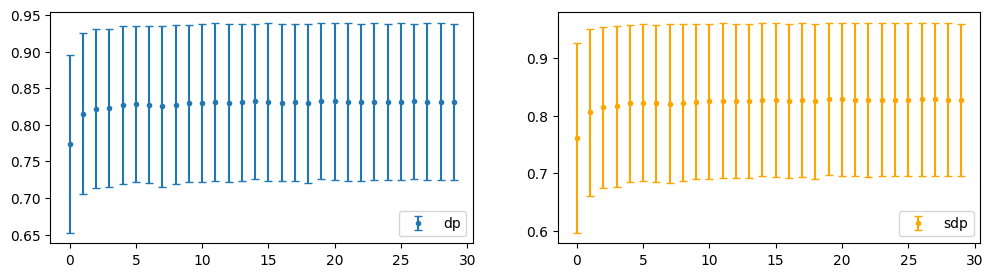

In [ ]:
plot_progres_bar(statistics_validation)

In [ ]:
def plot_median(statistics_validation):
    sorted_files = sorted(statistics_validation.keys(), key=get_validation_number)

    dpss = np.stack([statistics_validation[key][0] for key in sorted_files])
    dpss = np.sort(dpss)
    bs = dpss.shape[1]
    dpss_median = np.median(dpss,axis=1)
    dpss_percentile = dpss[:,(int(bs*.1), int(bs*.9))].T

    plt.figure(figsize=(18,12))
    plt.grid()
    plt.ylim(0.5,1)
    plt.errorbar(x=range(dpss.shape[0]),
                y=dpss_median,yerr=np.abs(dpss_percentile-dpss_median),
                linestyle='None',marker='.',capsize=3)
    plt.show()

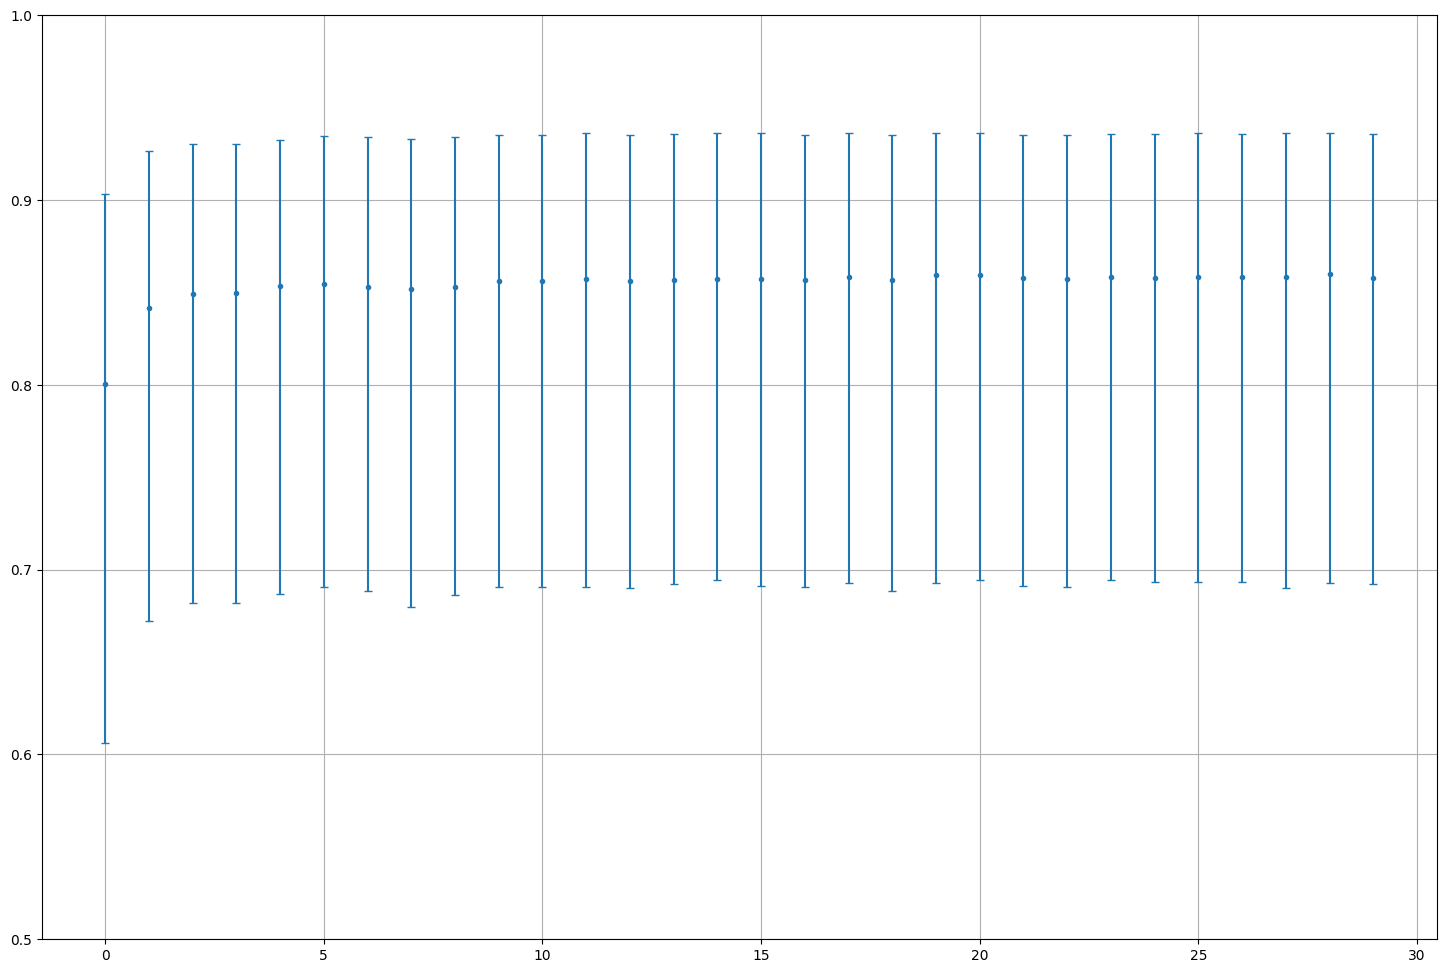

In [ ]:
plot_median(statistics_validation)

In [ ]:
def plot_boxplot_outliers(statistics_validation):
    sorted_files = sorted(statistics_validation.keys(), key=get_validation_number)

    dpss = np.stack([statistics_validation[key][0] for key in sorted_files])
    dpss = np.sort(dpss)
    plt.figure(figsize=(18,12))
    plt.boxplot(dpss.T)
    plt.show()

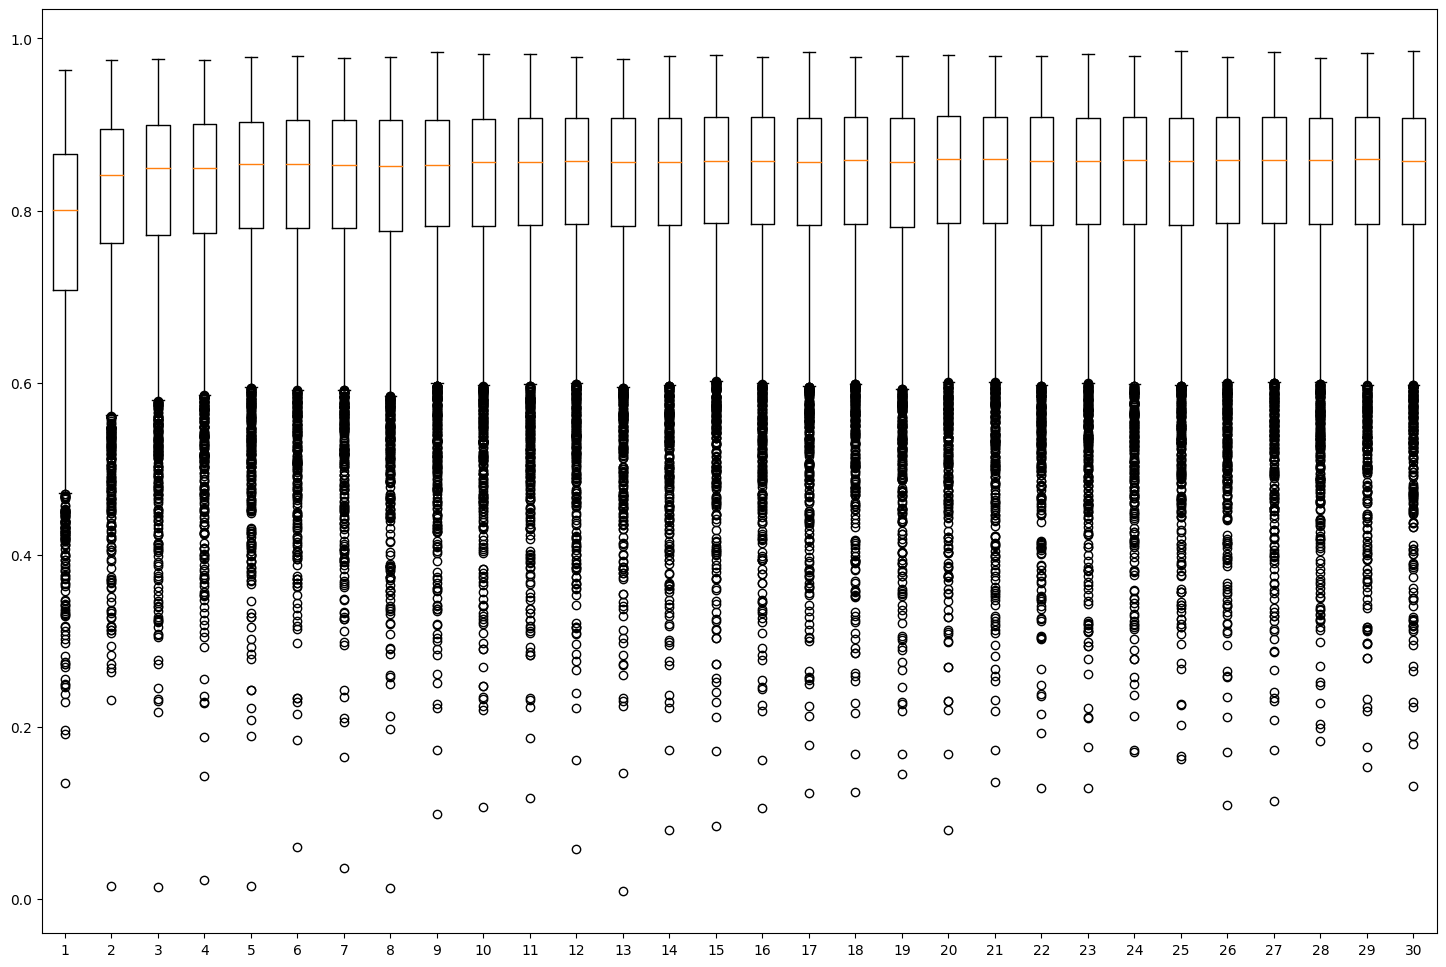

In [ ]:
plot_boxplot_outliers(statistics_validation)

# FINAL PREDICTION

In [ ]:
with open("/content/drive/MyDrive/NIST_ECF/Preprocessed_test_pow_ECF_small.output", 'rb') as handle:
    data_list_test  = pickle.load(handle)

In [ ]:
class ECFDataset(Dataset):
    def __init__(self, data):
        self.data = data
        
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, index):
        input_tensor, molecular_weight, output_tensor = self.data[index]

        return input_tensor, molecular_weight, output_tensor

In [ ]:
test_dataset = ECFDataset(data_list_test)

In [ ]:
model = model_base_big.DENSE_BIG()
checkpoint = torch.load("/content/drive/MyDrive/NIST_ECF/DENSE_BIG_ECF_POW/290.pt", map_location=torch.device('cpu'))
model.load_state_dict(checkpoint['model_state_dict'])
model.eval()

DENSE_BIG(
  (hidden1): Linear(in_features=1024, out_features=2000, bias=True)
  (skip1): SKIPblock(
    (batchNorm1): BatchNorm1d(2000, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu1): ReLU()
    (dropout1): Dropout(p=0.2, inplace=False)
    (hidden1): Linear(in_features=2000, out_features=1000, bias=True)
    (batchNorm2): BatchNorm1d(1000, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu2): ReLU()
    (dropout2): Dropout(p=0.2, inplace=False)
    (hidden2): Linear(in_features=1000, out_features=2000, bias=True)
  )
  (skip2): SKIPblock(
    (batchNorm1): BatchNorm1d(2000, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu1): ReLU()
    (dropout1): Dropout(p=0.2, inplace=False)
    (hidden1): Linear(in_features=2000, out_features=1000, bias=True)
    (batchNorm2): BatchNorm1d(1000, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu2): ReLU()
    (dropout2): Dropout(p=0.2, inplace=False)

In [ ]:
matchms.set_matchms_logger_level("ERROR")

test_loader_unshuffled = DataLoader(test_dataset, 
                         batch_size=BATCH, shuffle=False)

def validate_dataset(loader, model):
    # return 
    # true_list: list of true spetrum object
    
    pred_list = []
    true_list = []
    
    sim_dp = matchms.similarity.CosineGreedy(mz_power=1., intensity_power=.5)
    sim_sdp = matchms.similarity.CosineGreedy(mz_power=3., intensity_power=.6)

    dp =[]
    sdp = []
    with torch.no_grad():
        for batch in loader:
            # Use GPU
            x = batch[0].float().to(device)  
            molecular_weight = batch[1].to(device)  
            y = batch[2].to(device)        
            # Passing the node features and the connection info
            pred = model(x, molecular_weight) 

            for true_tensor, pred_tensor in zip(y, pred):
                true_spectrum = spectrum_preperation(true_tensor, MAX_INTENSITY)
                true_list.append(true_spectrum)

                pred_spectrum = spectrum_preperation(pred_tensor, MAX_INTENSITY)
                pred_list.append(pred_spectrum)

                dp.append(sim_dp.pair(true_spectrum, pred_spectrum))
                sdp.append(sim_sdp.pair(true_spectrum, pred_spectrum))


    dp = np.array([ float(s['score']) for s in dp ])
    sdp = np.array([ float(s['score']) for s in sdp ])
    return true_list, pred_list, dp, sdp

In [ ]:
true_list, pred_list, dp, sdp = validate_dataset(test_loader_unshuffled, model)

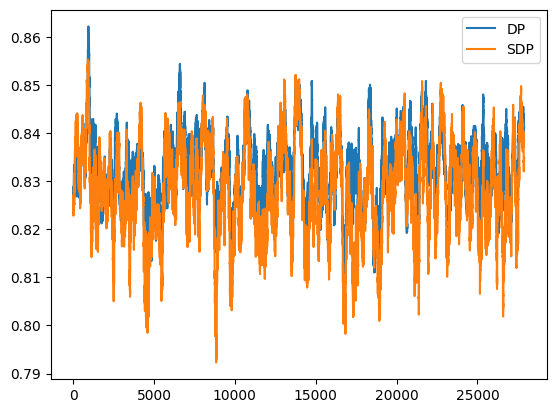

In [ ]:
win = 200
smooth_dp = np.convolve(dp, np.ones(win)/win, mode='valid')
smooth_sdp = np.convolve(sdp, np.ones(win)/win, mode='valid')

plt.plot(smooth_dp,label='DP')
plt.plot(smooth_sdp,label='SDP')
plt.legend()

plt.show()

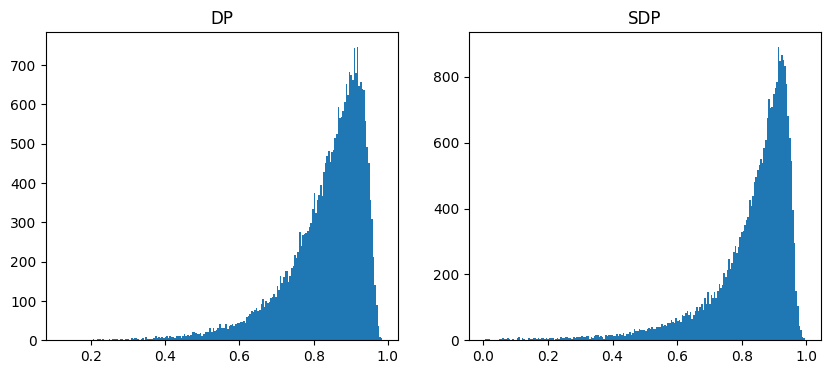

In [ ]:
bins = 200
plt.figure(figsize=(10,4))
plt.subplot(121)
plt.hist(dp,label='DP',bins=bins)
plt.title('DP')
plt.subplot(122)
plt.hist(sdp,label='SDP',bins=bins)
plt.title('SDP')
#lt.legend()
plt.show()

In [ ]:
print(f" | DotProduct mean is: {np.mean(dp)} and standard deviation is {np.std(dp)}")

print(f" | SteinDotProduct mean is: {np.mean(sdp)} and standard deviation is {np.std(sdp)}")

 | DotProduct mean is: 0.8323444243743462 and standard deviation is 0.10800070423987354
 | SteinDotProduct mean is: 0.8277569251936454 and standard deviation is 0.13552352963308578


In [ ]:
one_instance = DataLoader(test_dataset, 
                         batch_size=1, shuffle=False)

In [ ]:
def measure_time(loader, model):
    # return 
    # true_list: list of true spetrum object
   
    batch_times = []
    with torch.no_grad():
        for batch in loader:
                  
            x = batch[0].float().to(device)  
            molecular_weight = batch[1].to(device)  
            y = batch[2].to(device)

            start_time = time.time()

            pred = model(x, molecular_weight) 

            end_time = time.time()

            batch_time = end_time - start_time
            batch_times.append(batch_time)
    mean_batch_time = sum(batch_times) / len(batch_times)
    print(f"Mean time taken per batch: {mean_batch_time:.2f} seconds")
        
        

In [ ]:
measure_time(one_instance, model)

Mean time taken per batch: 0.03 seconds
